In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import statsmodels.api as sm
import matplotlib.pyplot as plt

from varclushi import VarClusHi

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, auc
from sklearn.linear_model import LinearRegression

from sklearn_pandas import DataFrameMapper
from sklearn2pmml.decoration import CategoricalDomain
from sklearn2pmml import sklearn2pmml
from sklearn2pmml.pipeline import PMMLPipeline
from sklearn2pmml.tree.chaid import CHAIDClassifier
from jpmml_evaluator import make_evaluator
from jpmml_evaluator.pyjnius import jnius_configure_classpath, PyJNIusBackend

In [2]:
df = pd.read_csv("mmf_data2.csv", encoding='utf-8')

## Q2: Data

In [3]:
# Q2.3: Target Variable
target_cols = [f"t{month}" for month in range(1, 13)]
df["target"] = df[target_cols].sum(axis=1).apply(lambda x: 1 if x else 0)

In [4]:
# Q2.4: Population Exclusions
print(f"number of customers in the population before exclusions: {df.shape[0]}")
df = df.drop(df[df["WIDELYHD"] == "Y"].index).reset_index(drop=True)
df = df.drop(df[df["deceased"] > 0].index).reset_index(drop=True)
print(f"number of customers in the population after exclusions: {df.shape[0]}")

number of customers in the population before exclusions: 9028
number of customers in the population after exclusions: 9012


In [5]:
# Q2.5: Modeling Population
default_counts = df["target"].value_counts()
print("total population")
print("number of default customers: ", default_counts[1])
print("number of non-default customers: ", default_counts[0])
print("default rate: ", default_counts[1]/df.shape[0])

default_counts_by_timekey = df.groupby("TIME_KEY").target.agg(['sum', 'count'])
time_key_dict = {
    15076: "2014-01",
    15196: "2014-04",
    15316: "2014-07",
    15436: "2014-10"
}
for key in time_key_dict:
    print(f"\n{time_key_dict[key]}")
    print("number of default customers: ", default_counts_by_timekey.loc[key, "sum"])
    print("number of non-default customers: ", default_counts_by_timekey.loc[key, "count"] - default_counts_by_timekey.loc[key, "sum"])
    print("default rate: ", default_counts_by_timekey.loc[key, "sum"] / default_counts_by_timekey.loc[key, "count"])

total population
number of default customers:  900
number of non-default customers:  8112
default rate:  0.09986684420772303

2014-01
number of default customers:  219
number of non-default customers:  1967
default rate:  0.10018298261665141

2014-04
number of default customers:  236
number of non-default customers:  2004
default rate:  0.10535714285714286

2014-07
number of default customers:  206
number of non-default customers:  2039
default rate:  0.09175946547884187

2014-10
number of default customers:  239
number of non-default customers:  2102
default rate:  0.10209312259718069


In [6]:
# Q2.6: Explanatory Variables
debit_cols = ["debit_curr"] + [f"debit_prev{month}" for month in range(1, 13)]
credit_cols = ["credit_curr"] + [f"credit_prev{month}" for month in range(1, 13)]

def get_linear_trend(row, t=np.arange(0, -13, -1)):
    reg = LinearRegression().fit(t.reshape(-1, 1), row.to_numpy())
    return reg.coef_[0]

df["debit_max"] = df[debit_cols].max(axis=1)
df["debit_min"] = df[debit_cols].min(axis=1)
df["debit_avg"] = df[debit_cols].mean(axis=1)
df["debit_stdev"] = df[debit_cols].std(axis=1)
df["debit_trend"] = df[debit_cols].apply(lambda row: get_linear_trend(row), axis=1)
debit_new_cols = ["debit_max", "debit_min", "debit_avg", "debit_stdev", "debit_trend"]

df["credit_max"] = df[credit_cols].max(axis=1)
df["credit_min"] = df[credit_cols].min(axis=1)
df["credit_avg"] = df[credit_cols].mean(axis=1)
df["credit_stdev"] = df[credit_cols].std(axis=1)
df["credit_trend"] = df[credit_cols].apply(lambda row: get_linear_trend(row), axis=1)
credit_new_cols = ["credit_max", "credit_min", "credit_avg", "credit_stdev", "credit_trend"]

df["debit_credit_ratio"] = df["debit_avg"] / df["credit_avg"]
# monthly debit-to-credit ratio variables (variance too large)
# df["debit_credit_ratio_curr"] = df["debit_curr"] / df["credit_curr"]
# ratio_cols = ["debit_credit_ratio_avg", "debit_credit_ratio_curr"]
# for month in range(1, 13):
#     df[f"debit_credit_ratio{month}"] = df[f"debit_prev{month}"] / df[f"credit_prev{month}"]
#     ratio_cols.append(f"debit_credit_ratio{month}")

new_cols = debit_new_cols + credit_new_cols + ["debit_credit_ratio"]

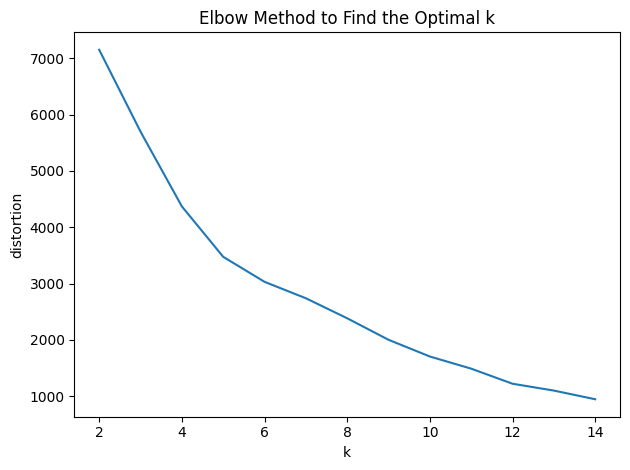

In [7]:
# Q2.7: Segmentation
cluster_cols = [
    'CUSTTYPE',
    'HIGHRISK',
    'STARTUP',
    'TERMCUST',
    'OLCUST',
    'VISACUST',
    'Out_of_Country',
    'SPP_Group_1',
    'SPP_Group_2',
    'DOCTOR_DENTIST_IND',
    'RESTAURANT_IND',
    'TRUCKING_IND',
    'RESTAURANT_OR_TRUCKING_IND',
    'SPP_LISTED_IND',
    'SPP_TARGETED_IND',
    'SPP_LISTED_OR_TARGETED_IND'
]

cluster_df = df.loc[:, cluster_cols]
for col in cluster_cols:
    # skip numeric variables
    if col == "CUSTTYPE":
        cluster_df["operating_account"] = cluster_df[col].map({"O": 1, "T": 0, "B": 1})
        cluster_df["term_account"] = cluster_df[col].map({"O": 0, "T": 1, "B": 1})
    else:
        cluster_df[col] = cluster_df[col].map({"Y": 1, "N": 0})

X_cluster = cluster_df.drop("CUSTTYPE", axis=1).to_numpy()
distortions = []
silhouette_scores = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=2000).fit(X_cluster)
    cluster_labels = kmeans.fit_predict(X_cluster)
    distortions.append(kmeans.inertia_)
    # silhouette_avg = silhouette_score(X_cluster, cluster_labels)
    # silhouette_scores.append(silhouette_avg)

fig, ax = plt.subplots()
ax.plot(np.arange(2, 15), distortions)
ax.set(xlabel="k", ylabel='distortion')
ax.set_title("Elbow Method to Find the Optimal k")
plt.tight_layout()
plt.savefig('media/kmeans.png')
plt.show()

# we select k = 5 as the optimal number of cluster
clusterer = KMeans(n_clusters=5, random_state=2000).fit(X_cluster)
cluster_labels = clusterer.fit_predict(X_cluster)
df["cluster_num"] = cluster_labels

# fig, ax = plt.subplots()
# ax.plot(np.arange(2, 15), silhouette_scores)
# ax.set(xlabel="k", ylabel='silhouette score')
# ax.set_title("Silhouette Analysis to Find the Optimal k")
# plt.tight_layout()
# plt.show()

## Q3: Scorecard Development

In [8]:
# Q3.2.1: Pre-Screening
processed_cols = [col[4:] for col in df.columns if col.startswith("GRP_")]
benchmark_cols = [col for col in df.columns if col.startswith("benchmark")]
population_exclusion_cols = ["WIDELYHD", "deceased"]
index_cols = ["tu_seq_id", "TIME_KEY"]
constant_cols = list(df.loc[:, df.nunique() == 1].columns)
# sparse_cols = list(df.loc[:, df.isna().sum() > 0.1*df.shape[0]].columns)
sparse_cols = list(df.loc[:, df.isna().sum() > 0].columns)

cols_to_ignore = sum(
    [
        processed_cols,
        target_cols, ["target"],
        benchmark_cols,
        new_cols,
        debit_cols,
        credit_cols,
        population_exclusion_cols,
        index_cols,
        constant_cols,
        sparse_cols
    ],
    []
)
prescreened_cols = [col for col in df.columns if not (col.startswith("GRP_") or col.startswith("WOE_") or col in cols_to_ignore)]

In [9]:
# Q3.2.2: Univariate Screening
def get_WOE_IV(df, col, preprocessed=False):
    df_groupby = df.groupby(col).target.agg(['sum', 'count'])
    df_groupby["f_B"] = df_groupby["sum"] / df.target.sum()  # distribution of default ("bad") customers
    df_groupby["f_G"] = (df_groupby["count"] - df_groupby["sum"]) / (df.shape[0] - df.target.sum())  # distribution of non-default ("good") customers
    if preprocessed:
        WOE_df = df[[col, "WOE_" + col.replace("GRP_", "")]].drop_duplicates()
        WOE_dict = dict(zip(WOE_df[col], WOE_df["WOE_" + col.replace("GRP_", "")]))
        df_groupby["WOE"] = df_groupby.index.to_series().map(WOE_dict)
    else:
        df_groupby["WOE"] = np.log(df_groupby["f_G"] / df_groupby["f_B"])
    df_groupby["IV"] = (df_groupby["f_G"] - df_groupby["f_B"]) * df_groupby["WOE"]
    return df_groupby


bins_dict = {
    "debit_max": np.linspace(25000, 50000, 11),
    "debit_min": [0, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 25000],
    "debit_avg": np.linspace(10000, 40000, 11),
    "debit_stdev": np.linspace(6000, 21000, 11),
    "debit_trend": [-4000, -2400, -1600, -800, 0, 800, 1600, 2400, 4000],
    "credit_max": [20000, 29000, 32000, 35000, 38000, 41000, 44000, 47000, 50000],
    "credit_min": [0, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 25000],
    "credit_avg": [10000, 16000, 19000, 22000, 25000, 28000, 31000, 34000, 37000, 40000],
    "credit_stdev": [6500, 9500, 11000, 12500, 14000, 15500, 17000, 18500, 21500],
    "credit_trend": [-4100, -2460, -1640, -820, 0, 820, 1640, 2460, 4100],
    "debit_credit_ratio": [0.3, 0.54, 0.78, 1.02, 1.26, 1.5, 1.74, 1.98, 2.7]
}

for col in new_cols:
    df[f"GRP_{col}"] = pd.cut(df[col], bins_dict[col], labels=np.arange(1, len(bins_dict[col])))
df["GRP_TBSAT01"] = pd.cut(df["TBSAT01"], [-8, -1, 0, 1, 2, 3, 4, 5, 7, 10, 30], labels=np.arange(1, 11))
df["WOE_TBSAT01"] = df["GRP_TBSAT01"].map(dict(zip(get_WOE_IV(df, "GRP_TBSAT01").index, get_WOE_IV(df, "GRP_TBSAT01").WOE)))
df["GRP_cust_max_dlq_3mos"] = pd.cut(df["cust_max_dlq_3mos"], [-1, 0, 1, 2, 6], labels=np.arange(1, 5))
df["WOE_cust_max_dlq_3mos"] = df["GRP_cust_max_dlq_3mos"].map(dict(zip(get_WOE_IV(df, "GRP_cust_max_dlq_3mos").index, get_WOE_IV(df, "GRP_cust_max_dlq_3mos").WOE)))

# encoding categorical variables
for col in prescreened_cols:
    # skip numeric variables
    if col in ['cust_max_dlq_3mos', 'agri_cust', 'TBSAT01']:
        continue
    elif col == "CUSTTYPE":
        df["operating_account"] = df[col].map({"O": 1, "T": 0, "B": 1})
        df["term_account"] = df[col].map({"O": 0, "T": 1, "B": 1})
    else:
        df[col] = df[col].map({"Y": 1, "N": 0})

# for col in new_cols:
#     df_groupby = get_WOE_IV(df, f"GRP_{col}")
#     print(col)
#     print(df_groupby)
#     print(df_groupby.IV.sum())

IV_dict = dict()
GRP_cols = [col for col in df.columns if col.startswith("GRP_")]  # this includes processed columns and new variables
cols_to_verify_with_IV = prescreened_cols + GRP_cols + ["operating_account", "term_account"]
for col in cols_to_verify_with_IV:
    # these variables have already been processed into different columns
    if col in ["CUSTTYPE", "TBSAT01", "cust_max_dlq_3mos"]:
        continue
    df_groupby = get_WOE_IV(df, col)
    # IV_dict[col] = df_groupby.IV.sum()
    IV_dict[col.replace("GRP_", "WOE_")] = df_groupby.IV.sum()
    # print(col, df_groupby.IV.sum())
    # print(df_groupby)

sorted_cols_by_IV = sorted(IV_dict.items(), key=lambda x: -x[1])
selected_cols = [x[0] for x in sorted_cols_by_IV if x[1] > 0.1]
selected_cols = [x for x in selected_cols if x not in ["Out_of_Country", "WOE_PD_Total_Scorecard_Points"]]

In [10]:
# Q3.2.3: Multivariate Screening
df_var_cluster = df.loc[:, selected_cols]
var_clusterer = VarClusHi(df_var_cluster, maxeigval2=2)
var_clusterer.varclus()
print(var_clusterer.info)
print(var_clusterer.rsquare)
df_rsquare_ratio = var_clusterer.rsquare
df_rsquare_ratio["IV"] = df_rsquare_ratio["Variable"].map(IV_dict)
cols_max_IV = df_rsquare_ratio[df_rsquare_ratio.groupby(['Cluster'])["IV"].transform(max) == df_rsquare_ratio["IV"]].Variable.to_numpy()
cols_min_ratio = df_rsquare_ratio[df_rsquare_ratio.groupby(['Cluster'])["RS_Ratio"].transform(min) == df_rsquare_ratio["RS_Ratio"]].Variable.to_numpy()
candidate_cols = list(cols_max_IV) + list(cols_min_ratio)
candidate_cols = sorted(list(set(candidate_cols)))

  Cluster N_Vars   Eigval1   Eigval2   VarProp
0       0     18  7.765835  1.829263  0.431435
1       1     12  7.593738  1.182550  0.632812
2       2      8  3.928507  1.516343  0.491063
3       3      8  4.200405  1.612878  0.525051
4       4      9  4.387612  1.523856  0.487512
5       5     12  6.544548  1.447001  0.545379
6       6     13  7.268132  1.592234  0.559087
7       7      4  2.768118  0.859483  0.692030
8       8      6  3.521030  0.857198  0.586838
9       9      9  5.336674  1.126232  0.592964
    Cluster        Variable    RS_Own     RS_NC  RS_Ratio
0         0     WOE_BCC5830  0.616866  0.310722  0.555848
1         0  WOE_CVPRAGG501  0.689049  0.272604  0.427486
2         0     WOE_BCA5030  0.660815  0.317916  0.497277
3         0  WOE_CVPRAGG907  0.654874  0.214634  0.439446
4         0     WOE_BCC3515  0.576050  0.258073  0.571417
..      ...             ...       ...       ...       ...
94        9    WOE_TBSAT33A  0.573834  0.322838  0.629341
95        9    WOE_

In [11]:
# Q2.8: Sampling Methodology (more convenient to split after processing)
df["cluster_num"] = cluster_labels
df_test = df[df["TIME_KEY"] == 15436].reset_index(drop=True)
df_intime = df[df["TIME_KEY"] != 15436].reset_index(drop=True)
dfs_test = [df_test[df_test.cluster_num == i].reset_index(drop=True) for i in range(5)]
dfs = [df_intime[df_intime.cluster_num == i].reset_index(drop=True) for i in range(5)]
dfs_train, dfs_val = [None for _ in range(5)], [None for _ in range(5)]
for i in range(5):
    dfs_train[i], dfs_val[i], _, _ = train_test_split(dfs[i], dfs[i]["target"], stratify=dfs[i]["target"], test_size=0.2, random_state=2000)

In [12]:
# Q3.3: Model Fitting
models = []
final_cols = []
for i in range(5):
    print(f"model {i}:")
    curr_cols = candidate_cols
    model = sm.Logit(dfs_train[i].target, dfs_train[i].loc[:, curr_cols]).fit(disp=False)
    min_bic = model.bic
    while True:
        best_model = None
        best_bic = np.inf
        best_col = None
        for subset in list(itertools.combinations(curr_cols, len(curr_cols)-1)):
            reg = sm.Logit(dfs_train[i].target, dfs_train[i].loc[:, subset]).fit(disp=False)
            if reg.bic < best_bic:
                best_bic = reg.bic
                best_model = reg
                best_col = subset
        if best_bic < min_bic:
            min_bic = best_bic
            model = best_model
            curr_cols = best_col
        else:
            break
    models.append(model)
    final_cols.append(curr_cols)
    print(model.summary())
    # for table in model.summary().tables:
    #     print(table.as_latex_tabular())

model 0:
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                  548
Model:                          Logit   Df Residuals:                      541
Method:                           MLE   Df Model:                            6
Date:                Sun, 11 Dec 2022   Pseudo R-squ.:                 0.01223
Time:                        15:04:33   Log-Likelihood:                -182.81
converged:                       True   LL-Null:                       -185.07
Covariance Type:            nonrobust   LLR p-value:                    0.6057
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
WOE_ALL2327              -0.6772      0.246     -2.756      0.006      -1.159      -0.196
WOE_BCC5830               0.6995      0.280      2.500      0.012       0.151       1.248

In [20]:
# Q3.4: Scorecard Scaling
factor = 20 / np.log(2)
offset = 600 - factor*np.log(50)
scorecards = []
for i in range(5):
    GRP_cols = [col.replace("WOE_", "GRP_") for col in final_cols[i]]
    GRP_dict = dict(df[GRP_cols].nunique())
    n = len(final_cols[i])  # number of explanatory variables in the model
    scorecard_temps = []
    for col in final_cols[i]:
        scorecard_temp = pd.DataFrame(np.arange(1, GRP_dict[col.replace("WOE_", "GRP_")]+1), columns=['GRP'])
        WOE_dict = df[[col.replace("WOE_", "GRP_"), col]].set_index(col.replace("WOE_", "GRP_")).to_dict()[col]
        scorecard_temp["WOE"] = scorecard_temp["GRP"].map(WOE_dict)
        scorecard_temp["score"] = offset/n - factor * scorecard_temp.WOE * models[i].params[col]
        scorecard_temp.insert(0, "variable", col.replace("WOE_", ""))
        scorecard_temps.append(scorecard_temp)
    scorecard = pd.concat(scorecard_temps).reset_index(drop=True)
    scorecard["score"] = scorecard["score"].apply(lambda x: round(x))  # round to the nearest integer for business purposes
    scorecards.append(scorecard)
    # print(i)
    # print(scorecard.style.to_latex())

KS statistic of the model: 0.6039 at score = 499


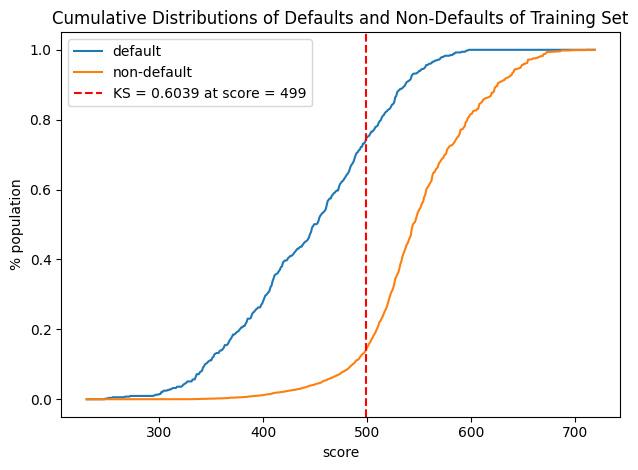

KS statistic of the model: 0.6248 at score = 503


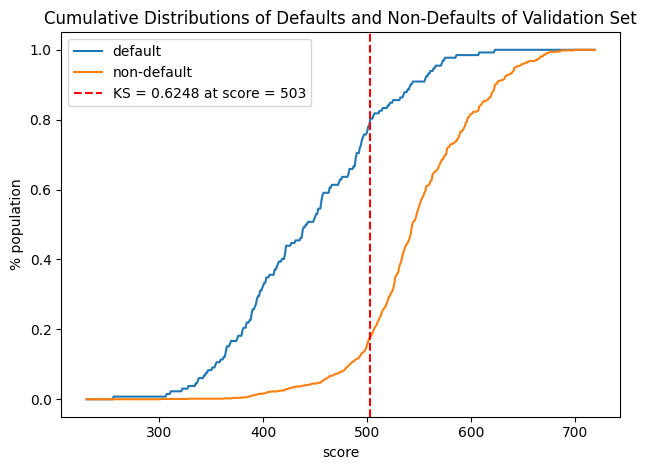

KS statistic of the model: 0.5998 at score = 505


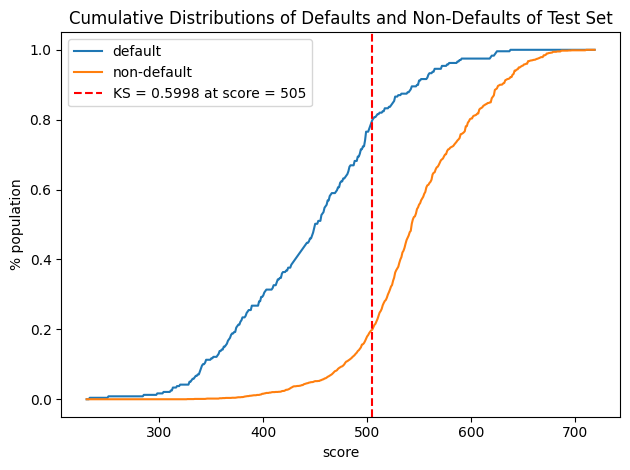

KS statistic of the model: 0.6365 at score = 500


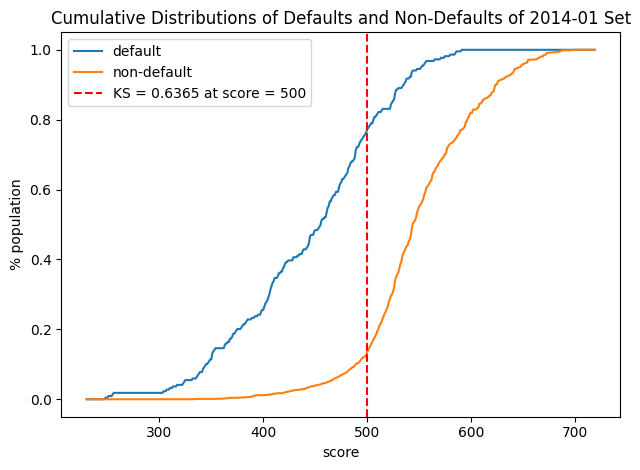

KS statistic of the model: 0.5869 at score = 492


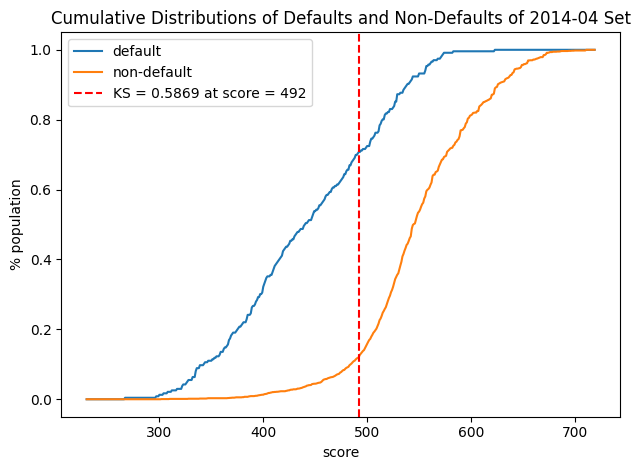

KS statistic of the model: 0.6155 at score = 499


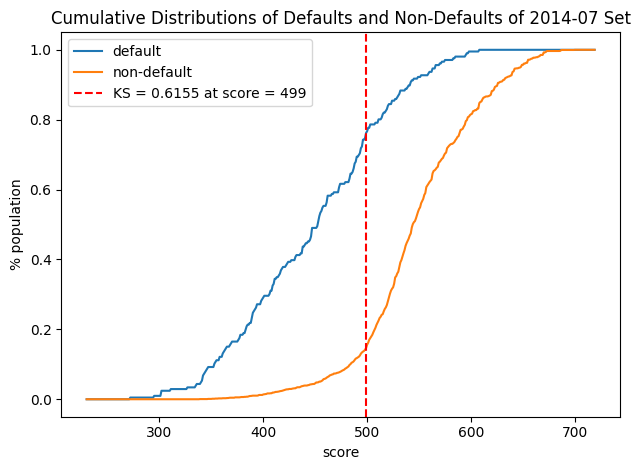

KS statistic of the model: 0.5998 at score = 505


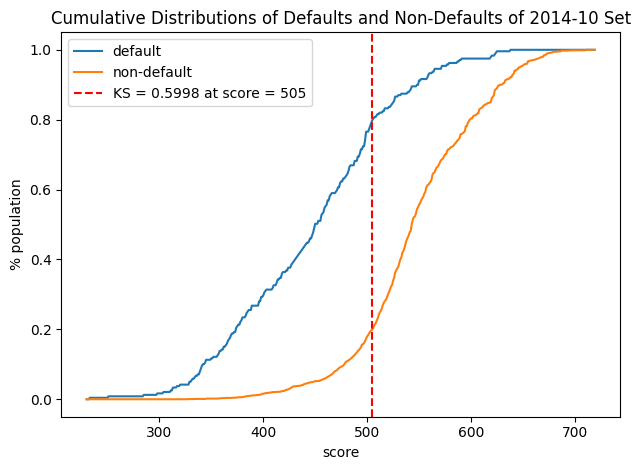

accuracy ratio (AR) of the model: 0.7423


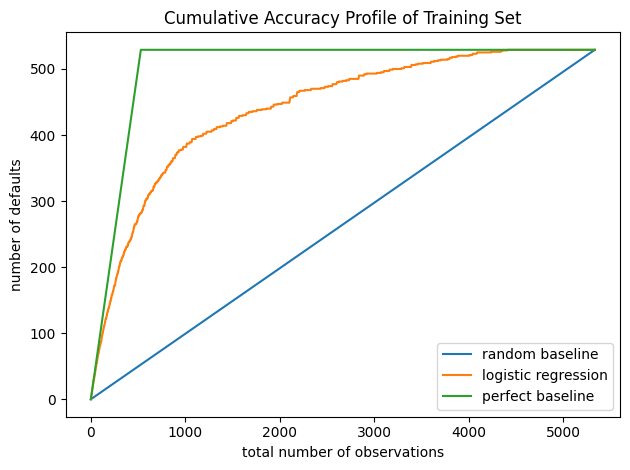

accuracy ratio (AR) of the model: 0.7269


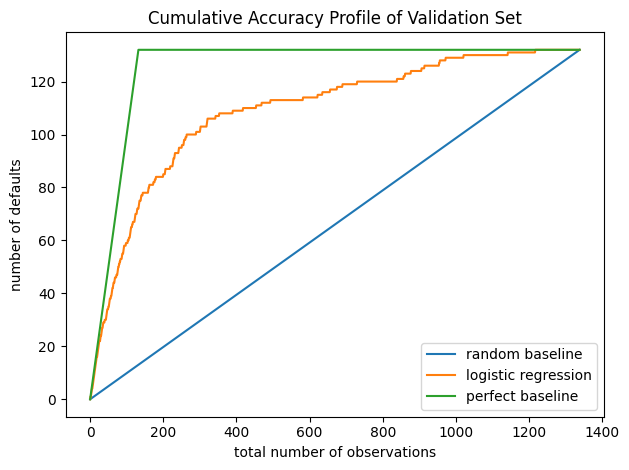

accuracy ratio (AR) of the model: 0.7011


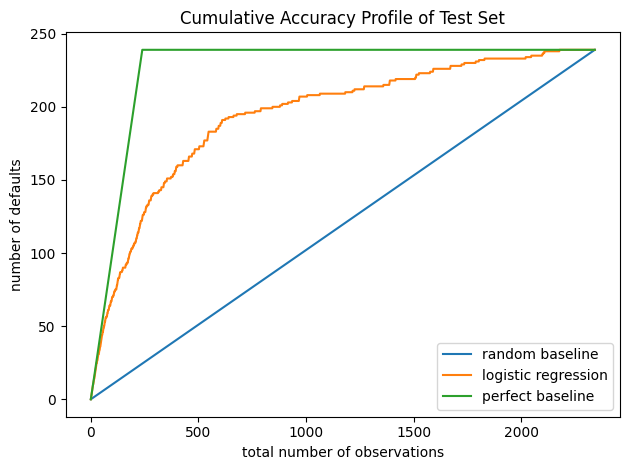

accuracy ratio (AR) of the model: 0.7613


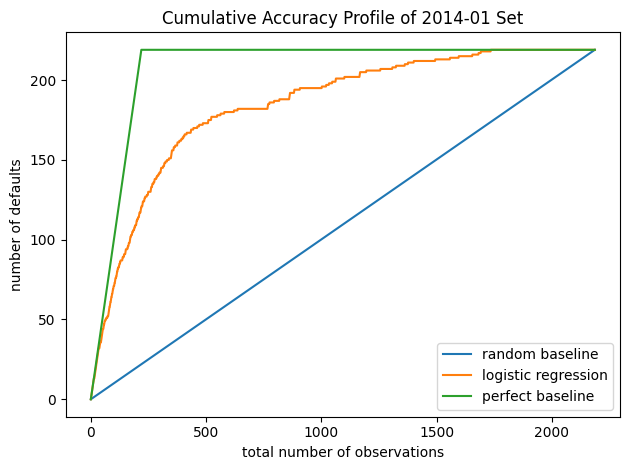

accuracy ratio (AR) of the model: 0.7333


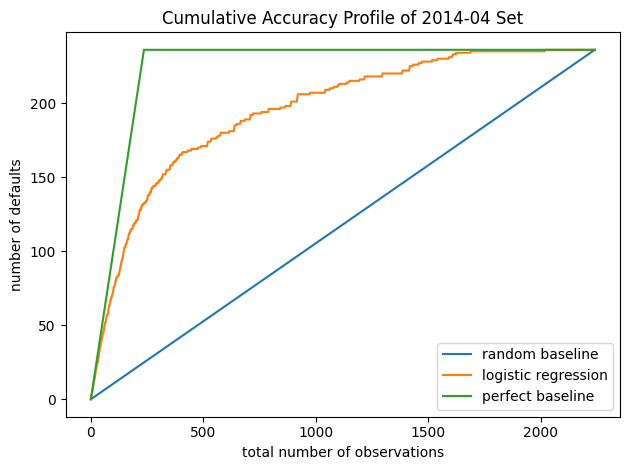

accuracy ratio (AR) of the model: 0.7238


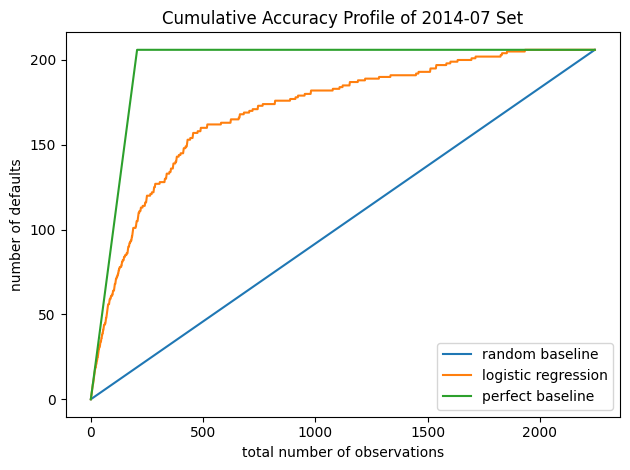

accuracy ratio (AR) of the model: 0.7011


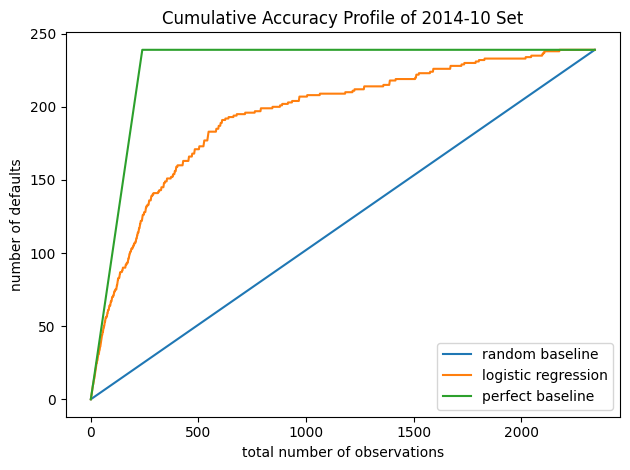

lift at 10% of the model: 5.333813311958916


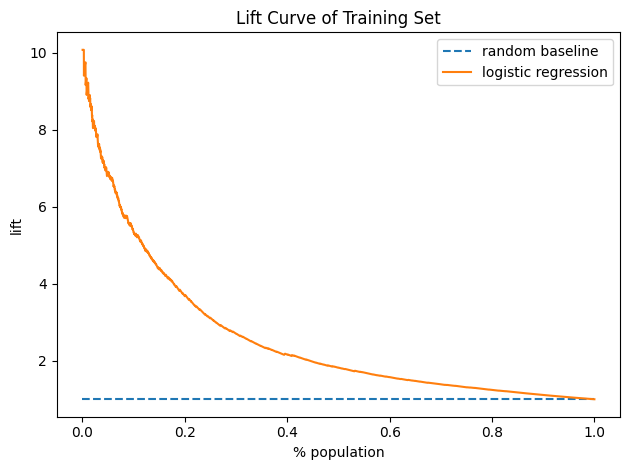

lift at 10% of the model: 5.563568010936431


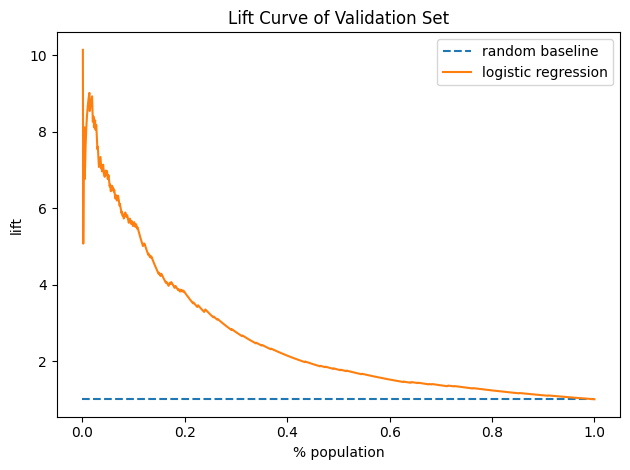

lift at 10% of the model: 5.10678396452455


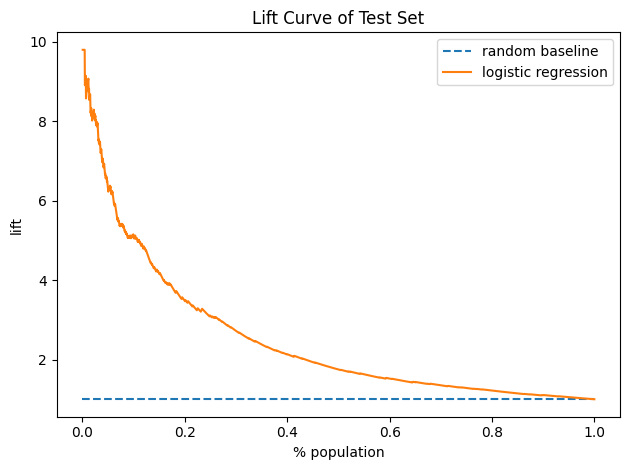

lift at 10% of the model: 5.4945331154957895


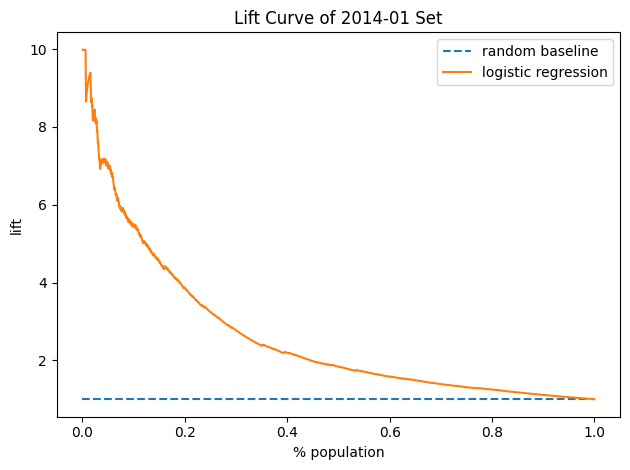

lift at 10% of the model: 5.466101694915253


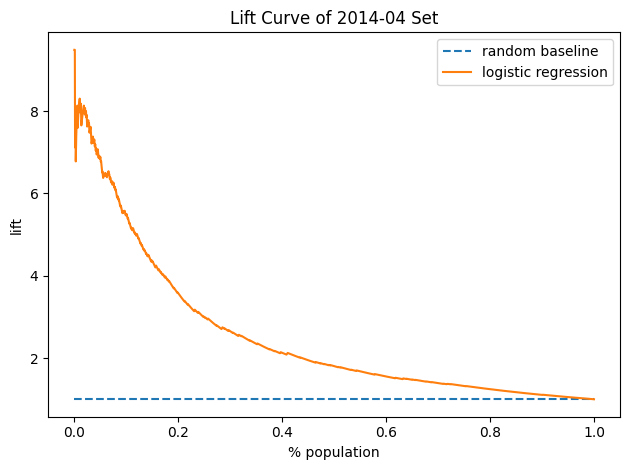

lift at 10% of the model: 5.4976811719833565


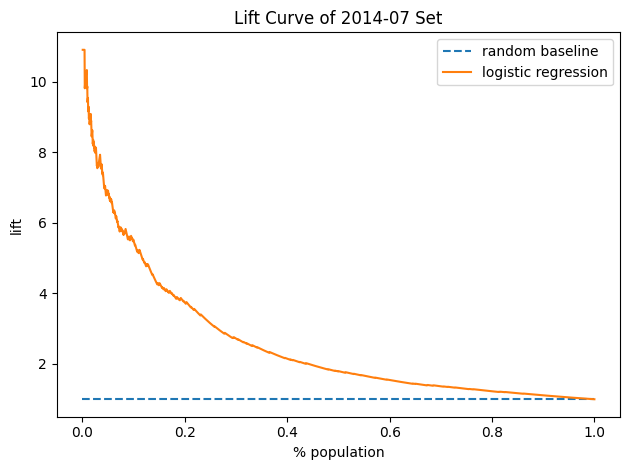

lift at 10% of the model: 5.10678396452455


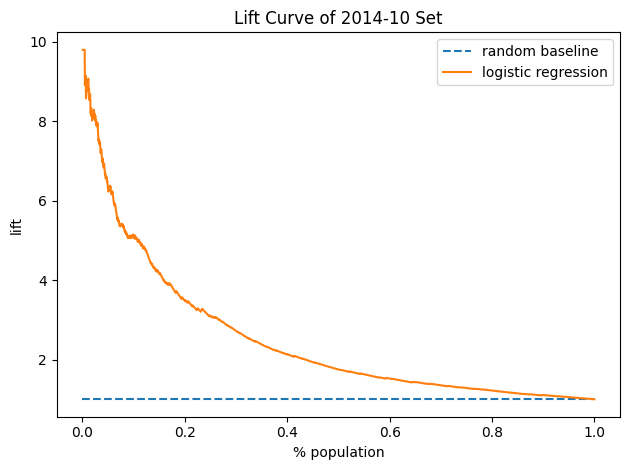

In [14]:
# Q3.5.1: Rank-Ordering
def generate_score(df):
    def scoring(row):
        cluster_num = row.cluster_num
        score = 0
        for col in final_cols[cluster_num]:
            scorecard = scorecards[cluster_num]
            score += scorecard[(scorecard.variable == col.replace("WOE_", "")) & (scorecard.GRP == row[col.replace("WOE_", "GRP_")])].score.to_numpy()
        return score[0]
    df["score"] = df.apply(lambda row: scoring(row), axis=1)
    return df


# split by train-val-test sets
df_train = pd.concat(dfs_train).reset_index(drop=True)
df_val = pd.concat(dfs_val).reset_index(drop=True)
# df_test has already been created above
df_train_scored = generate_score(df_train.copy())
df_val_scored = generate_score(df_val.copy())
df_test_scored = generate_score(df_test.copy())

# split by time
dfs_time_scored = [generate_score(df[df.TIME_KEY == tk].copy()) for tk in time_key_dict]


## KS statistic
def get_KS(df_scored, scores, plot_title_type):
    default_count = [df_scored[(df_scored.target == 1) & (df_scored.score == s)].shape[0] for s in scores]
    non_default_count = [df_scored[(df_scored.target == 0) & (df_scored.score == s)].shape[0] for s in scores]
    default_cum_dist = np.cumsum(default_count) / np.sum(default_count)
    non_default_cum_dist = np.cumsum(non_default_count) / np.sum(non_default_count)
    KS = scores[np.argmax([d - nd for d, nd in zip(default_cum_dist, non_default_cum_dist)])]
    KS_index = list(scores).index(KS)
    print(f"KS statistic of the model: {(default_cum_dist[KS_index] - non_default_cum_dist[KS_index]):.4f} at score = {KS}")

    fig, ax = plt.subplots()
    ax.plot(scores, default_cum_dist, label="default")
    ax.plot(scores, non_default_cum_dist, label="non-default")
    ax.axvline(x=KS, color='r', label=f"KS = {(default_cum_dist[KS_index] - non_default_cum_dist[KS_index]):.4f} at score = {KS}", linestyle="dashed")
    ax.set(xlabel="score", ylabel='% population')
    ax.set_title(f"Cumulative Distributions of Defaults and Non-Defaults of {plot_title_type} Set")
    ax.legend()
    plt.tight_layout()
    plt.savefig(f'media/KS_{plot_title_type.lower()}.png')
    plt.show()
    
    return KS


scores = np.arange(230, 720)
get_KS(df_train_scored, scores, "Training")
get_KS(df_val_scored, scores, "Validation")
get_KS(df_test_scored, scores, "Test")
for i, tk in enumerate(time_key_dict):
    get_KS(dfs_time_scored[i], scores, time_key_dict[tk])


## accuracy ratio
def get_AR(df_scored, plot_title_type, model_type="logistic regression"):
    sorted_scores = [y for _, y in sorted(zip(df_scored.score.to_numpy(), df_scored.target.to_numpy()), reverse=False)]
    total_default = df_scored.target.sum()
    yy = np.append([0], np.cumsum(sorted_scores))
    xx = np.arange(0, df_scored.shape[0]+1)
    
    a = auc([0, df_scored.shape[0]], [0, total_default])  # area under the random baseline
    aP = auc([0, total_default, df_scored.shape[0]], [0, total_default, total_default]) - a  # area between the perfect and random baseline
    aR = auc(xx, yy) - a  # area between the trained model and the random baseline
    AR = aR / aP
    print(f"accuracy ratio (AR) of the model: {AR:.4f}")
    
    fig, ax = plt.subplots()
    ax.plot([0, df_scored.shape[0]], [0, total_default], label="random baseline")
    ax.plot(xx, yy, label=model_type)
    ax.plot([0, total_default, df_scored.shape[0]], [0, total_default, total_default], label="perfect baseline")
    ax.set(xlabel="total number of observations", ylabel='number of defaults')
    ax.set_title(f"Cumulative Accuracy Profile of {plot_title_type} Set")
    ax.legend()
    plt.tight_layout()
    plt.savefig(f'media/AR_{plot_title_type.lower()}.png')
    plt.show()
    
    return AR


get_AR(df_train_scored, "Training")
get_AR(df_val_scored, "Validation")
get_AR(df_test_scored, "Test")
for i, tk in enumerate(time_key_dict):
    get_AR(dfs_time_scored[i], time_key_dict[tk])


# lift curve
def get_lift(df_scored, plot_title_type, model_type="logistic regression"):
    sorted_scores = [y for _, y in sorted(zip(df_scored.score.to_numpy(), df_scored.target.to_numpy()), reverse=False)]
    total_default = df_scored.target.sum()
    xx = np.arange(1, df_scored.shape[0]+1) / df_scored.shape[0]
    yy = (np.cumsum(sorted_scores) / total_default) / xx
    lift_10 = yy[int(df_scored.shape[0] / 10) - 1]
    print(f"lift at 10% of the model: {lift_10}")
    
    fig, ax = plt.subplots()
    ax.plot([0, 1], [1, 1], label="random baseline", linestyle='dashed')
    ax.plot(xx, yy, label=model_type)
    ax.set(xlabel="% population", ylabel='lift')
    ax.set_title(f"Lift Curve of {plot_title_type} Set")
    ax.legend()
    plt.tight_layout()
    plt.savefig(f'media/lift_{plot_title_type.lower()}.png')
    plt.show()
    
    return lift_10


get_lift(df_train_scored, "Training")
get_lift(df_val_scored, "Validation")
get_lift(df_test_scored, "Test")
for i, tk in enumerate(time_key_dict):
    get_lift(dfs_time_scored[i], time_key_dict[tk])

PSI between 2014-01 and 2014-04: 0.004781219896646793
PSI between 2014-01 and 2014-07: 0.0062382490718950155
PSI between 2014-01 and 2014-10: 0.008508651978135913
PSI between 2014-04 and 2014-07: 0.006953117254680229
PSI between 2014-04 and 2014-10: 0.0038557418220195334
PSI between 2014-07 and 2014-10: 0.01019058862210121


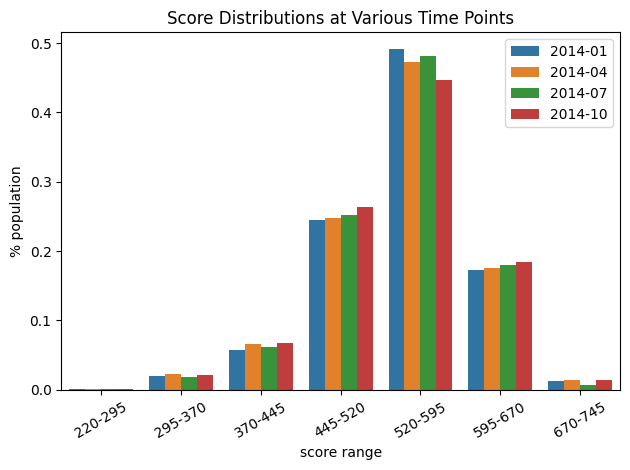

In [15]:
# Q3.5.2: Population Stability
bins = np.arange(220, 795, 75)
buckets = [f"{x}-{x+75}" for x in np.arange(220, 720, 75)]
df_psi = pd.DataFrame(buckets, columns=["bin"])
for i, tk in enumerate(time_key_dict):
    df_psi[time_key_dict[tk]] = df_psi["bin"].map(dict(pd.cut(dfs_time_scored[i]["score"], bins, labels=buckets).value_counts())) / dfs_time_scored[i].shape[0]
# df_psi["training"] = df_psi["bin"].map(dict(pd.cut(df_train_scored["score"], bins, labels=buckets).value_counts())) / df_train_scored.shape[0]
# df_psi["validation"] = df_psi["bin"].map(dict(pd.cut(df_val_scored["score"], bins, labels=buckets).value_counts())) / df_val_scored.shape[0]
# df_psi["test"] = df_psi["bin"].map(dict(pd.cut(df_test_scored["score"], bins, labels=buckets).value_counts())) / df_test_scored.shape[0]


def get_PSI(df, col_x, col_y):
    df_psi_temp = (df[col_x] - df[col_y]) * np.log(df[col_x] / df[col_y])
    return df_psi_temp.sum()


for col_x, col_y in itertools.combinations(time_key_dict.keys(), 2):
    col_x, col_y = time_key_dict[col_x], time_key_dict[col_y]
    print(f"PSI between {col_x} and {col_y}: {get_PSI(df_psi, col_x, col_y)}")

df_psi = df_psi.melt(id_vars=["bin"]).rename(columns={"variable": "time", "value": "distribution"})
fig, ax = plt.subplots()
sns.barplot(x='bin', y='distribution', hue='time', data=df_psi, ax=ax)
ax.set(xlabel="score range", ylabel='% population')
ax.set_title(f"Score Distributions at Various Time Points")
ax.legend()
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig('media/psi.png')
plt.show()

KS statistic of the model: 0.6547 at score = 549


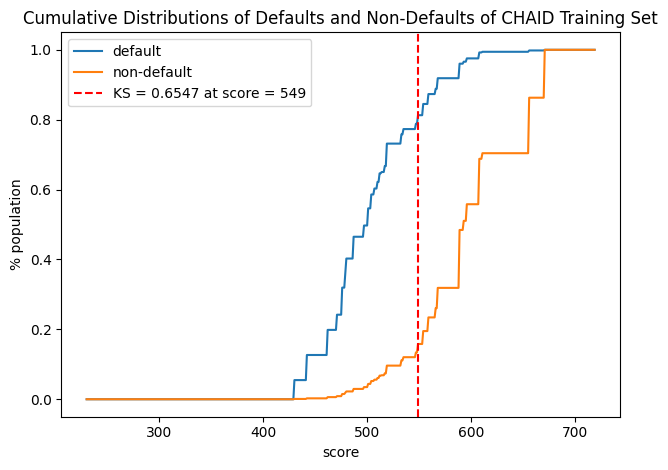

KS statistic of the model: 0.6246 at score = 554


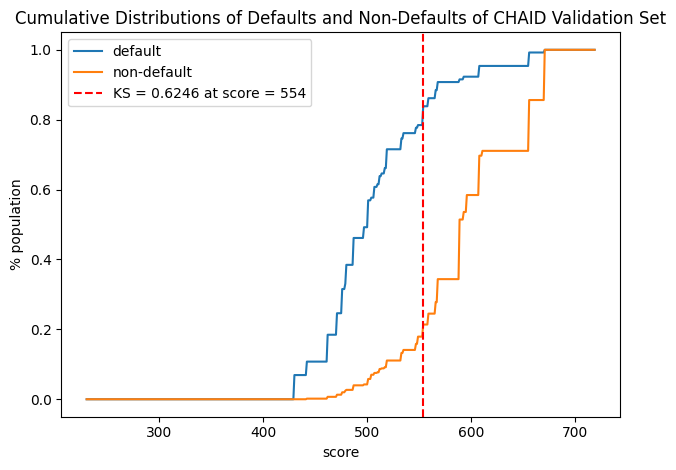

KS statistic of the model: 0.6016 at score = 554


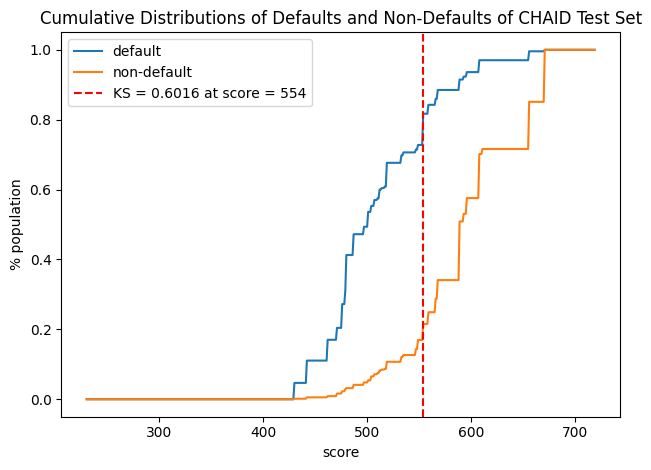

KS statistic of the model: 0.6617 at score = 554


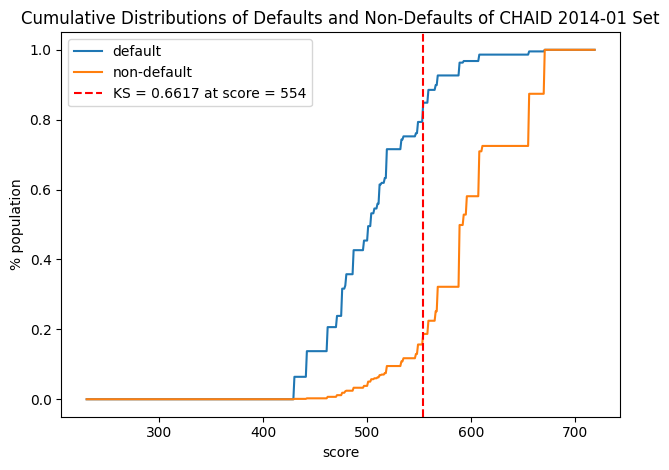

KS statistic of the model: 0.6748 at score = 547


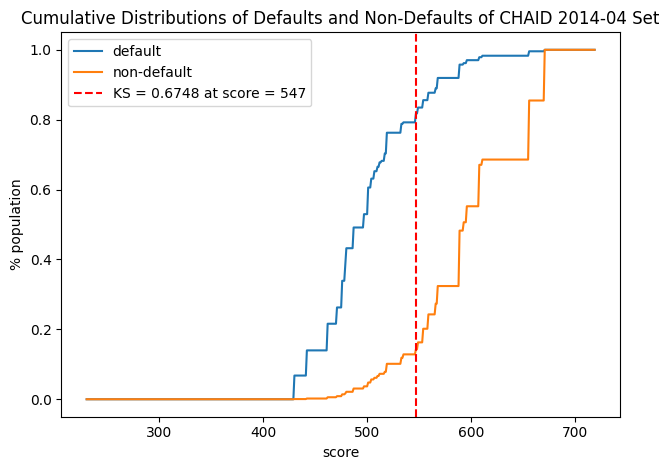

KS statistic of the model: 0.6383 at score = 535


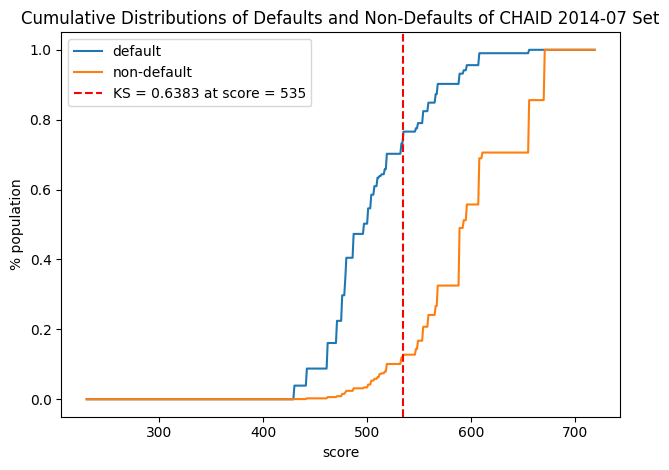

KS statistic of the model: 0.6016 at score = 554


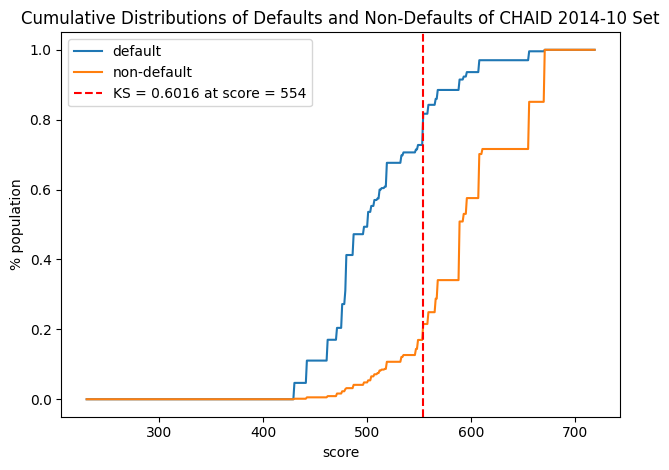

accuracy ratio (AR) of the model: 0.7964


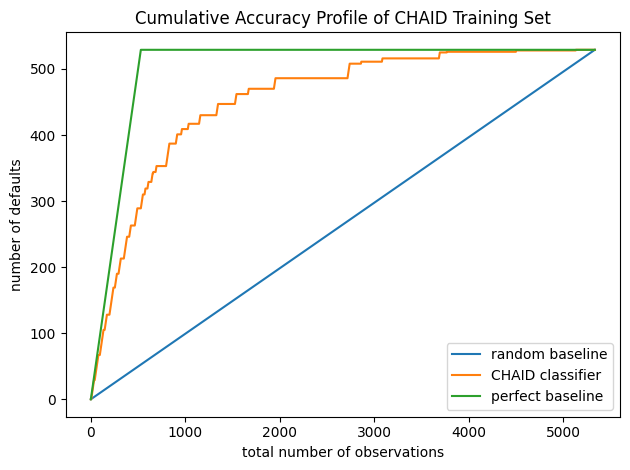

accuracy ratio (AR) of the model: 0.7081


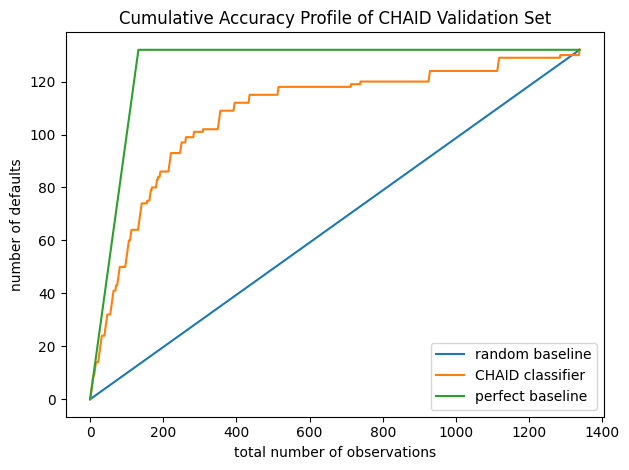

accuracy ratio (AR) of the model: 0.6854


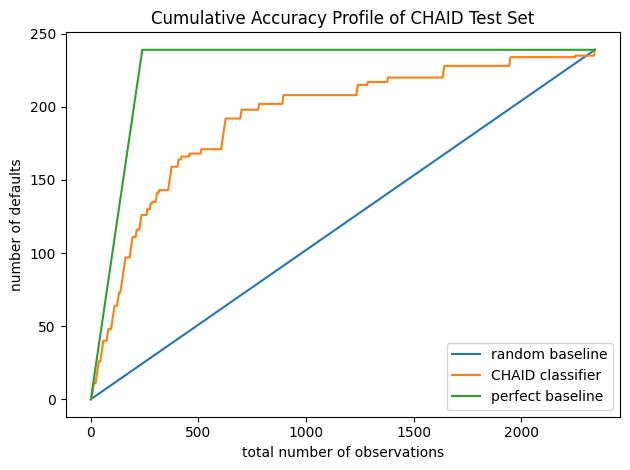

accuracy ratio (AR) of the model: 0.7751


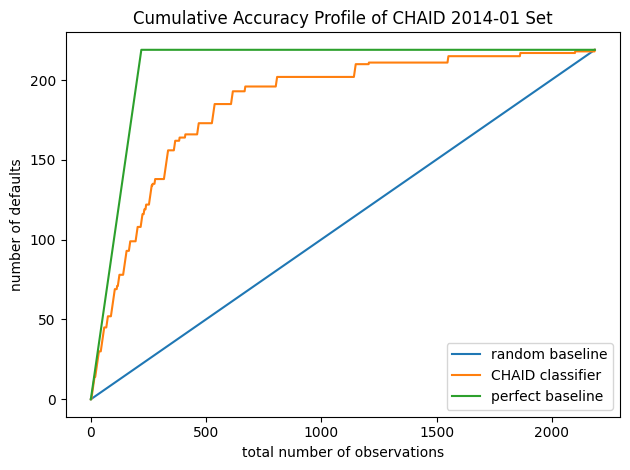

accuracy ratio (AR) of the model: 0.7992


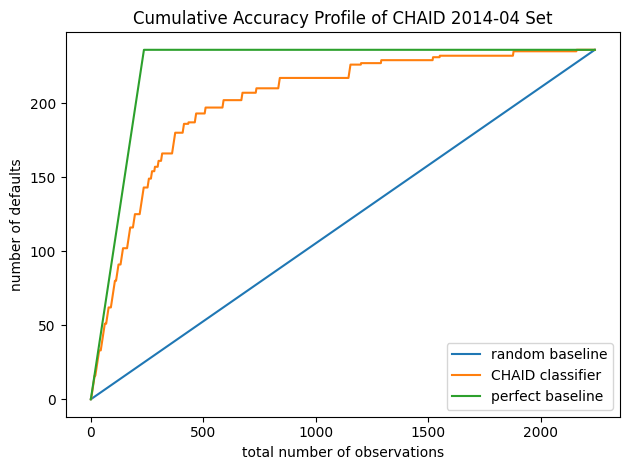

accuracy ratio (AR) of the model: 0.7596


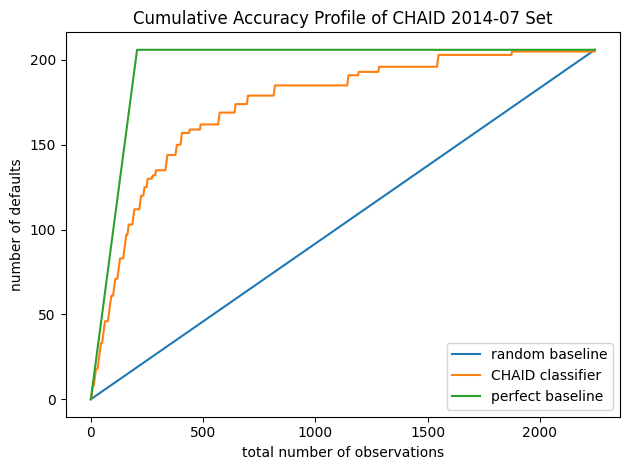

accuracy ratio (AR) of the model: 0.6854


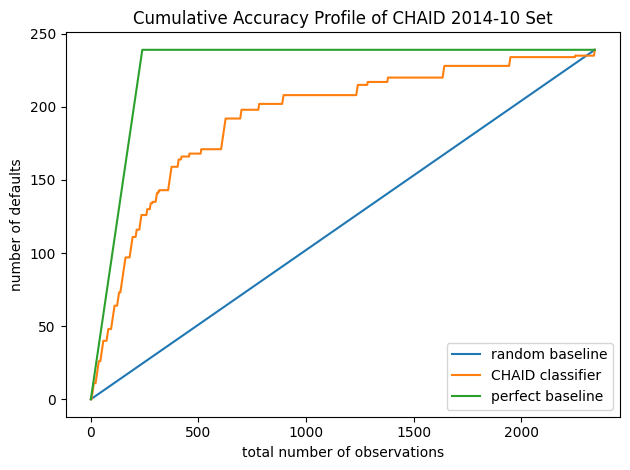

lift at 10% of the model: 5.541869859588519


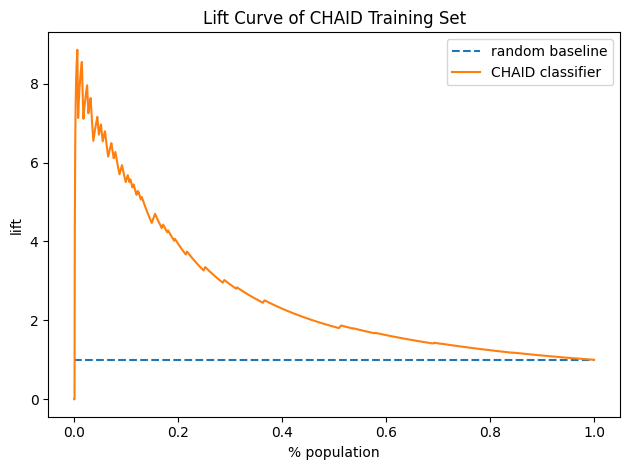

lift at 10% of the model: 5.030075187969924


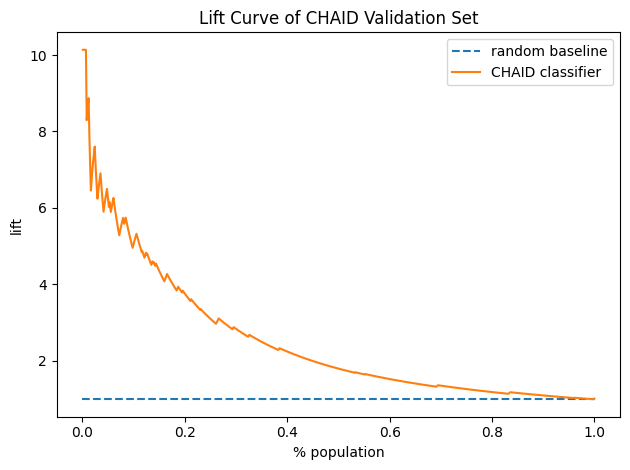

lift at 10% of the model: 5.232360619389908


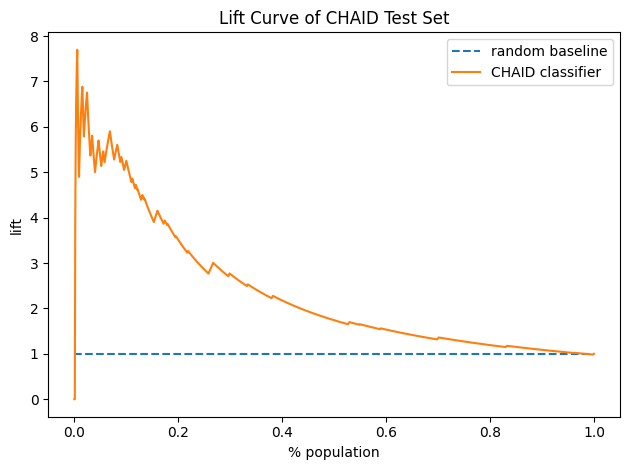

lift at 10% of the model: 5.03665535587114


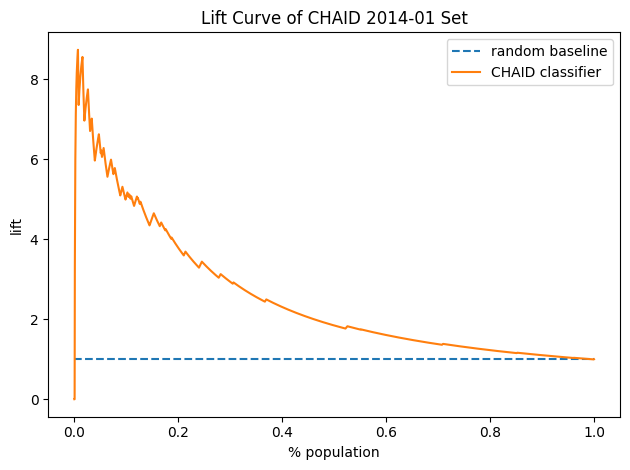

lift at 10% of the model: 5.59322033898305


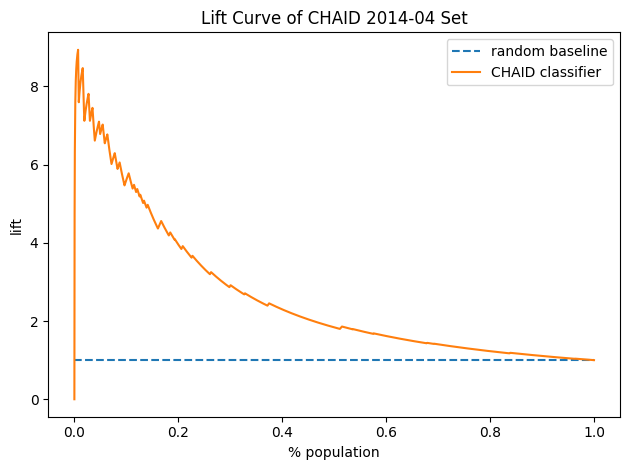

lift at 10% of the model: 5.838245492371706


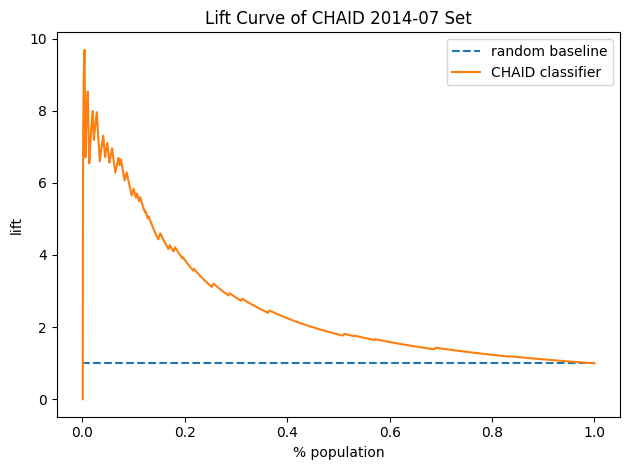

lift at 10% of the model: 5.232360619389908


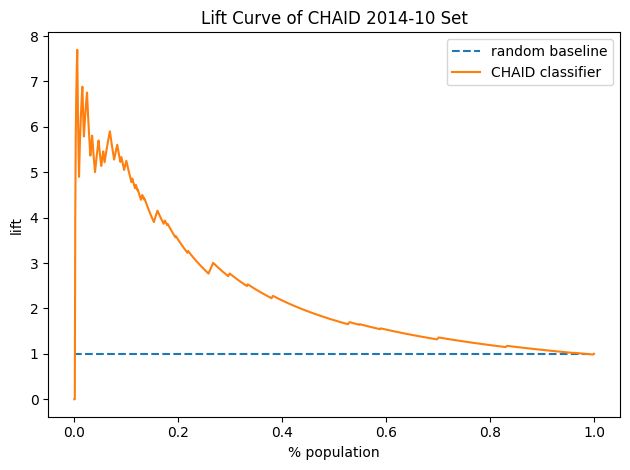

In [16]:
# Q3.5.3: Scorecard Benchmarking
def make_passthrough_mapper(cols):
    return DataFrameMapper([([col], CategoricalDomain()) for col in cols])


def make_classifier(max_depth=5):
    config = {
        "max_depth" : max_depth
    }
    return CHAIDClassifier(config = config)


pipeline = PMMLPipeline(
    [
        ("mapper", make_passthrough_mapper(candidate_cols)),
        ("classifier", make_classifier(max_depth=5))
    ]
)
pipeline.fit(df_train.loc[:, candidate_cols], df_train.target)
sklearn2pmml(pipeline, "CHAID.pmml")

# initialize Python-to-Java connectivity
try:
    jnius_configure_classpath()
except:
    print("VM already running")
backend = PyJNIusBackend()

# load model
evaluator = make_evaluator(backend, "CHAID.pmml").verify()


def generate_score_CHAID(df, evaluator, factor, offset):
    eps = 1e-4  # to prevent inf score
    df_pred = evaluator.evaluateAll(df)
    df["score"] = np.round(np.log(1 / (df_pred["probability(1)"] + eps) - 1)*factor + offset)
    return df


df_train_scored_CHAID = generate_score_CHAID(df_train.copy(), evaluator, factor, offset)
df_val_scored_CHAID = generate_score_CHAID(df_val.copy(), evaluator, factor, offset)
df_test_scored_CHAID = generate_score_CHAID(df_test.copy(), evaluator, factor, offset)
dfs_time_scored_CHAID = [generate_score_CHAID(df[df.TIME_KEY == tk].copy().reset_index(drop=True), evaluator, factor, offset) for tk in time_key_dict]


## KS
scores = np.arange(230, 720)
get_KS(df_train_scored_CHAID, scores, "CHAID Training")
get_KS(df_val_scored_CHAID, scores, "CHAID Validation")
get_KS(df_test_scored_CHAID, scores, "CHAID Test")
for i, tk in enumerate(time_key_dict):
    get_KS(dfs_time_scored_CHAID[i], scores, f"CHAID {time_key_dict[tk]}")


## AR
get_AR(df_train_scored_CHAID, "CHAID Training", "CHAID classifier")
get_AR(df_val_scored_CHAID, "CHAID Validation", "CHAID classifier")
get_AR(df_test_scored_CHAID, "CHAID Test", "CHAID classifier")
for i, tk in enumerate(time_key_dict):
    get_AR(dfs_time_scored_CHAID[i], f"CHAID {time_key_dict[tk]}", "CHAID classifier")


# lift curve
get_lift(df_train_scored_CHAID, "CHAID Training", "CHAID classifier")
get_lift(df_val_scored_CHAID, "CHAID Validation", "CHAID classifier")
get_lift(df_test_scored_CHAID, "CHAID Test", "CHAID classifier")
for i, tk in enumerate(time_key_dict):
    get_lift(dfs_time_scored_CHAID[i], f"CHAID {time_key_dict[tk]}", "CHAID classifier")